In [464]:
aa_map = pd.read_csv('../src_data/aa_chart.csv', index_col=None)
str(list(aa_map['Function']))
AA = list('FYWAVILMSTNQPGDEKHRC')
NUM = [0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 3, 4, 5, 5, 6, 6, 6, 7]
EIIP = [0.0946, 0.0516, 0.0548, 0.0373, 0.0057, 0.0, 0.0, 0.0823,\
                     0.0829, 0.0941, 0.0036, 0.0761, 0.0198, 0.005, 0.1263, 0.0058, \
                     0.0371, 0.0242, 0.0959, 0.0829]
FNS = ['Aromatic', 'Aromatic', 'Aromatic', 'Hydrophobic', 'Hydrophobic', \
                    'Hydrophobic', 'Hydrophobic', 'Hydrophobic', 'Polar', 'Polar', 'Polar', \
                    'Polar', 'Proline', 'Glycine', 'Charge (-)', 'Charge (-)', 'Charge (+)', \
                    'Charge (+)', 'Charge (+)', 'Excluded']
AA_map = dict.fromkeys(["NUM", "EIIP", "FNS"])
for conv in list(AA_map.keys()):
    AA_map[conv] = dict(zip(AA, EIIP))
# ---- helper lambda functions
AA_conv = lambda typ, pep: [AA_map[typ][AA] if AA in AA else 0 for AA in pep]

print(AA_map)
print(list(AA_map.keys()))
for p in grbp5_sim.pep_data['Sequences']:
    pass
print(grbp5_sim.data['BLOSUM']['A']['B'])

{'NUM': {'F': 0.0946, 'Y': 0.0516, 'W': 0.0548, 'A': 0.0373, 'V': 0.0057, 'I': 0.0, 'L': 0.0, 'M': 0.0823, 'S': 0.0829, 'T': 0.0941, 'N': 0.0036, 'Q': 0.0761, 'P': 0.0198, 'G': 0.005, 'D': 0.1263, 'E': 0.0058, 'K': 0.0371, 'H': 0.0242, 'R': 0.0959, 'C': 0.0829}, 'EIIP': {'F': 0.0946, 'Y': 0.0516, 'W': 0.0548, 'A': 0.0373, 'V': 0.0057, 'I': 0.0, 'L': 0.0, 'M': 0.0823, 'S': 0.0829, 'T': 0.0941, 'N': 0.0036, 'Q': 0.0761, 'P': 0.0198, 'G': 0.005, 'D': 0.1263, 'E': 0.0058, 'K': 0.0371, 'H': 0.0242, 'R': 0.0959, 'C': 0.0829}, 'FNS': {'F': 0.0946, 'Y': 0.0516, 'W': 0.0548, 'A': 0.0373, 'V': 0.0057, 'I': 0.0, 'L': 0.0, 'M': 0.0823, 'S': 0.0829, 'T': 0.0941, 'N': 0.0036, 'Q': 0.0761, 'P': 0.0198, 'G': 0.005, 'D': 0.1263, 'E': 0.0058, 'K': 0.0371, 'H': 0.0242, 'R': 0.0959, 'C': 0.0829}}
['NUM', 'EIIP', 'FNS']
-2


In [112]:
'''
Class to calculate several simialrity metrics for an input list of peptides given a sequence string to compare it to.
USAGE: 
1. Create SequenceSimilarityObject({sequence string}, {dictionary of data paths} (to be deprecated soon -- use
   internal class data), {path to peptides csv}, {column title of sequence values of aforementioned peptides csv})
   for any number of sequences you want to be compared to the list of peptides
2. For each object, call object.generate_similarity() to fill out the Dataframe with similarity metrics
3. To whittle down this similarity matrix to list only those peptides with pattern matching of a minimum length
   at a matching index in the rerence peptide (henceforth the binder), call object.get_df_with_binder_subseqs(min_length={#})
@ Author: Chris Pecunies, with help from Savvy Gupta and Aaron Tsang
@ Date: February 12, 2020
'''
import pandas as pd
import numpy as np
from scipy.stats import kendalltau
import matplotlib.pyplot as plt
from typing import Set, Tuple, Dict, List
from scipy import interpolate
from scipy import stats
import textdistance as td

class SequenceSimilarity:
    '''
    Class that takes in a path to a list of amino acid sequences as well
    as any number of peptide sequences explicitly that are known to have
    a certain set of properties. Generates metrics for similarity for each
    peptide in path and returns domains AA sequence with high similarity
    '''

    def __init__(self, binder: str,
                 binder_name: str,
                 data_paths: Dict,     #@TODO Make another .py file containing object version of necessary sim matrices/conversions, etc.
                 peps_path: str,       #      to reduce reliance on outside data
                 aa_col: str,
                 dists: bool = False,
                 only_matching: bool = False):         #-> The column in peps_path csv where sequences are held
        
        # ---- setting data ---------
        self.AA = list('FYWAVILMSTNQPGDEKHRC')
        self.conv = ["NUM", "EIIP", "FNS"]
        self.conv_cols = [conv+'_Seq' for conv in self.conv]
        self.con_vals = dict.fromkeys(self.conv)
        self.con_vals['NUM'] = [0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 3, 4, 5, 5, 6, 6, 6, 7]
        self.con_vals['EIIP'] = [0.0946, 0.0516, 0.0548, 0.0373, 0.0057, 0.0, 0.0, 0.0823,\
                     0.0829, 0.0941, 0.0036, 0.0761, 0.0198, 0.005, 0.1263, 0.0058, \
                     0.0371, 0.0242, 0.0959, 0.0829]
        self.con_vals['FNS'] = ['Aromatic', 'Aromatic', 'Aromatic', 'Hydrophobic', 'Hydrophobic', \
                    'Hydrophobic', 'Hydrophobic', 'Hydrophobic', 'Polar', 'Polar', 'Polar', \
                    'Polar', 'Proline', 'Glycine', 'Charge (-)', 'Charge (-)', 'Charge (+)', \
                    'Charge (+)', 'Charge (+)', 'Excluded']
        self.AA_map = dict.fromkeys(self.conv)
        for conv in self.conv:
            self.AA_map[conv] = dict(zip(self.AA, self.con_vals[conv]))
        self.binder = binder   # to get binder_len, just use len(self.binders)
        self.bname = binder_name
        self.__read_similarity_data(data_paths) # !TO BE DEPRECATED! Just store data in class
        
        # ---- helper lambda functions
        self.AA_conv = lambda typ, pep: tuple(self.AA_map[typ][AA] if AA in self.AA else 0 for AA in pep)
        self.get_sim = lambda p1, p2, t: sum([self.data[t][a1][a2] for a1 in p1 for a2 in p2])
        
        # ---- setting up dataframes
        # @TODO: It looks like some sequences show up as duplicates in the overall sequence list
        #        OR some sequences are being overwritten / returned multiple times? Find out why
        #        this is and debug
        self.aa_col = aa_col
        self.sim_cols = ['PAM30', 'BLOSUM', 'RRM_SN', 'RRM_Corr']
        self.columns = [*self.sim_cols] + [*self.conv_cols]
        ## @TODO: Add "# of matching sseqs, cross entropy AA, cross entropy Num columns ?"
        
        self.peps = pd.read_csv(peps_path)
        self.peps.columns = [aa_col]
        self.peps = self.peps.drop_duplicates()
        self.peps = self.peps[~self.peps[self.aa_col].str.contains("O")]
        self.peps_same_len = self.peps[self.peps[aa_col].str.len() == len(binder)]
        if len(self.peps_same_len) == 0:
            raise Exception("No peptides of same length as binder found")
        self.pep_data = self.peps_same_len.copy()
        for col in self.columns:
            self.pep_data[col] = None
        self.update_similarities(use_distance=True)
        self.pep_match = self.get_df_with_binder_subseqs()
        if only_matching: self.pep_data = self.pep_match
        
    #----------------SET UP FUNCTIONS (void)-------------------------------#

    def __read_similarity_data(self, data_path_dict) -> None:
        """
        Private method to store the paths of any data needed
        for similarity calcs and create Dataframes from them
        """
        self.data = dict.fromkeys(data_path_dict.keys())
        for data in self.data.keys():
            self.data[data] = pd.read_csv(data_path_dict[data], index_col=0)
            self.data[data] = self.data[data].to_dict()
            
    def _update_AA_conversion(self) -> None:
        """if seq.signaltonoise(cross) < max(sn):
        Adds to the initially empty column values for conv_type (possible choices
        'EIIP' and 'Num' for now) the conversion of the AA sequence in the self.aa_col
        column a list representing its conversion
        """
        for conv in self.conv:
            if conv == 'NUM':
                out = []
                for p in self.pep_data[self.aa_col]:
                    num_list = self.AA_conv(conv, p)
                    s = ''
                    for n in num_list:
                        s += str(n)
                    out.append(s)
                self.pep_data[conv+"_Seq"] = out
            else:
                self.pep_data[conv+"_Seq"] = [self.AA_conv(conv, p) for p in self.pep_data[self.aa_col]]
    
    def _update_matrix_similarity(self) -> None:
        """
        Just updates the similarity columns for the output similarity dataframe.
        Uses lambda helper function self.get_sim in __init__
        """
        for data in self.data.keys():
            sim = [self.get_sim(p, self.binder, data) for p in self.pep_data[self.aa_col]]
            self.pep_data[data] = np.interp(sim, (min(sim), max(sim)), (0,1))
        

    def _update_RRM_similarity(self) -> None:
        """
        Uses the Resonant Recognition Model as described by Irena Cosic to 
        """
        get_dft_from_eiip = lambda ls: np.real(np.fft.rfft(ls))
        get_cross_spectrum = lambda p1, p2: [x1*x2 for x1, x2 in zip(p1, p2)]
        bnd_eiip = self.AA_conv('EIIP', self.binder)
        bnd_dft = get_dft_from_eiip(bnd_eiip)
        sn = []
        do = []
        best_sn = None
        best_dot = None
        
        def signaltonoise(a, axis=0, ddof=0):
            a = np.asanyarray(a)
            m = a.mean(axis)
            sd = a.std(axis=axis, ddof=ddof)
            return np.where(sd == 0, 0, m/sd)
        
        for pep in self.pep_data[self.aa_col]:
            seq_eiip =self.AA_conv('EIIP', pep)
            seq_dft = get_dft_from_eiip(seq_eiip)
            cross = get_cross_spectrum(seq_dft, bnd_dft)
            dot = np.dot(seq_dft, bnd_dft)
            SN = np.mean(np.real(signaltonoise(cross, axis=None)))
            do.append(dot)
            sn.append(SN)
            if not sn and SN >= max(sn):
                best_sn = (pep, seq_dft)
            if not do or dot >= max(do):
                best_dot = (pep, seq_dft)
            
        sn_out = np.interp(sn, (min(sn), max(sn)), (0,1))
        dot_out = np.interp(do, (min(do), max(do)), (0,1))
        self.pep_data['RRM_Corr'] = dot_out
        self.pep_data['RRM_SN'] = sn_out
    
    # NOTE! Adds columns "Matching_sseqs" and "Num_matching" to output
    # Might be too unwieldy / unhelpful for output similarity data
    # if so, just comment out _update_matching_sseqs()
    def _update_matching_sseqs(self, single_match_weight:float = 1, weight:float = 1.5) -> None:
        """
        Returns a number as a new column representing the number of "matches" a peptide
        has for all possible subsequences for the binder inputted at a given index. For
        weighting=1, all matches are treated equally ('Y' at position 3 is treated equal
        to IMV at position 0) but lowering weighting lowers smaller-length matches
        """
        # @TODO Remove "duplicates" which occur at different matching indexes of binder
        # but are part of a larger pattern already recorded at an earlier index
        self.pep_data['sseq_matches'] = None
        self.pep_data['weighted_matches'] = None
        
        score = lambda s: (single_match_weight * 1) + (len(s)**weight)
        all_sseqs = self.get_binder_subseq()
        matches = list(); num_matches = list()
        for i, seq in enumerate(self.pep_data[self.aa_col]):
            matches.append([]); num_matches.append(0)
            longest_match = None
            for j, AA in enumerate(seq): #-----------goes thru each sequence
                prev_match: Tuple = None
                for k, (sseq, bin_i) in enumerate(all_sseqs): #---------for each AA in seq, then go through all sseq and indexes
                    if (bin_i == j) and (seq[j:len(sseq)+j] == sseq): #--- if AA matches sseq and index of pep == index of sseq:
                        if longest_match is not None:
                            if seq[longest_match[1]:longest_match[1]+longest_match[2]].find(seq[j:len(sseq)+j]) >= 0:
                                continue
                        prev_binder_i: int = all_sseqs[k-1][1]
                        prev_binder_sseq: str = all_sseqs[k-1][0]
                        if prev_binder_i == bin_i:
                            num_matches[i] -= score(matches[i].pop()[0])
                            longest_match = (sseq, bin_i, len(sseq))
                        matches[i].append((sseq, bin_i))   
                        num_matches[i] += score(sseq)
                        prev_match = (sseq, bin_i)
        
        self.pep_data['sseq_matches'] = [*matches]
        self.pep_data['weighted_matches'] = np.interp(num_matches, (min(num_matches), max(num_matches)), (0,1))
        self.sim_cols += ['weighted_matches']
        self.columns += ['sseq_matches', 'weighted_matches']
        
                    
    def _remove_matching_sseqs_column(self) -> None:
        """
        Just removes the binder sseq pattern matches list column and number
        of matching (with/without) weighting if they exist
        """
        for col in ['sseq_matches', 'weighted_matches']:
            if self.pep_data.columns.contains(['sseq_matches', 'weighted_matches']):
                self.pep_data = self.pep_data.drop(columns=['sseq_matches', 'weighted_matches'])
                self.columns.remove(col)
            self.sim_cols.remove('weighted_matches')
            
    def _update_distances(self, metrics: List = []) -> None:
        """
        Adds Hamming, Levenstein, etc. distance metrics for sequences in peptide list
        Metrics can be specified by name string in parameter
        """
        distances = {
            'jaro_winkler': (lambda p1, p2: td.jaro_winkler.normalized_similarity(p1, p2)),
            'needleman_wunsch': (lambda p1, p2: td.needleman_wunsch.normalized_similarity(p1, p2)),
            'smith_waterman': (lambda p1, p2: td.smith_waterman.normalized_similarity(p1, p2)),
            'levenshtein': (lambda p1, p2: td.levenshtein.normalized_similarity(p1, p2)),
        }
        dists = list(distances.keys()) if len(metrics)==0 else metrics
        data = pd.DataFrame(index=self.pep_data.index, columns=dists)
        for dist in dists:
            self.pep_data[dist] = [distances[dist](pep, self.binder) for pep in self.pep_data[self.aa_col]]
        self.columns += dists
        self.sim_cols += dists
        
    def _unpack_num_encoding(self) -> None:
        for i, num_tup in enumerate(list(self.pep_data['NUM_Seq'])):
            for j, num in enumerate(num_tup):
                self.pep_data['Nm_'+str(j)].iloc[i]
                
                
    def update_similarities(self, use_distance=False, metrics: List = []) -> None:
        '''
        Updates the similarity values whenever called (for now should be only once right
        after creating the object, ecept possibly if the Binding peptide is updated
        (should be handled automatically)
        '''
        self._update_AA_conversion()
        self._update_matrix_similarity()
        self._update_RRM_similarity()
        self._update_matching_sseqs()
        if use_distance:
            if len(metrics) == 0:
                self._update_distances()
            else:
                self._update_distances(metrics)
        # OPTIONAL
        # self._unpack_num_encoding()
        
    #----------MAIN CLASS FUNCTIONS (returns data) ------------------------#

    def df_filter_subseq(self, sub_seq: str, ind: int = None) -> pd.DataFrame:
        '''
        Takes in a subsequence of equal or lesser length to
        peptides in class peptide dataframe and returns a dataframe
        containing only those peptides containing the sequence
        '''
        if not {*sub_seq}.issubset({*self.AA}):
            raise Exception('Invalid subsequence')
        if ind is None:
            return self.pep_data[self.pep_data[self.aa_col].str.contains(sub_seq)]
        return self.pep_data[self.pep_data[self.aa_col].str.find(sub_seq) == ind]

    def get_sim_matrix(self, seq) -> pd.DataFrame:
        return self.data.filter

    def get_binder_subseq(self) -> pd.DataFrame: #Each binder associated with list of (sseq, index)
        '''
        Generates all possible subsequences for binders. Returns ia list of tuples, where
        each entry of the list is of the form ({Sub Seq}, {Ind}) of binder
        '''
        self.sseqs = [(self.binder[i:j], i) for i in range(len(self.binder)) for j in range(i+1, len(self.binder)+1)]
        return self.sseqs


    #@FIXME: Returns some rows with no pattern matches
    def get_df_with_binder_subseqs(self, min_length: int = 0) -> Dict[str, pd.DataFrame]:
        '''
        Returns a filtered version of self.peps_same_len DataFrame containing only
        those rows with sequences which contain subsequences (of min length specified in parameter) 
        of the two binder sequences in the locations where they occur in the binders
        '''
        # @TODO Check that the output df is actually right
        sseq = self.get_binder_subseq()
        self.pep_match = pd.concat([self.df_filter_subseq(ss,i) for (ss,i) in sseq if len(ss) >= min_length])
        return self.pep_match
        
    
    def merge_data(self, other, sep_cols = False) -> pd.DataFrame:
        # !!! IMPORTANT: "other" must also be SequenceSimilarity object (couldnt compile)
        """
        Returns a merged Dataframe of self.pep_data and another SequenceSimilarity's pep_data.
        If sep_cols=True, then the other SequenceSimilarity's columns will simply be appended
        to the returned DataFrame (self.pep_data is unchanged). If False, results will be averaged.
        @NOTE: This is a super naive implementatoin -- expand this to make it more configurable
        @TODO: Take in *others as a list of arbitrarily many other SequenceSimilarities to compare
        """
        # must be same length binders -> so same peptides of interest
        this_data = self.pep_data.copy()
        non_seq_cols = self.sim_cols.copy()
        seq_cols = [self.aa_col] + [*self.conv_cols]
        other_data = other.pep_data.copy()
        if sep_cols:
            if len(list(this_data.columns)) == len(list(other_data.columns)):
                return this_data.merge(right=other_data, on=self.aa_col, suffixes=("_"+self.bname, "_"+other.bname))        
            else:
                raise Exception("Mismatched columns")

        new_cols = ['{}_{}_{}'.format(col, self.bname, other.bname) for col in self.sim_cols]
        out_data = pd.DataFrame(index=this_data.index, columns=seq_cols + new_cols)
        out_data[seq_cols] = this_data[seq_cols]
        both = pd.concat([this_data[non_seq_cols],other_data[non_seq_cols]])
        out_data[new_cols] = both.groupby(both.index).mean()
        if 'sseq_matches' in self.columns or 'sseq_matches' in other.columns:
            both_match = self.pep_data['sseq_matches'].append(other.pep_data['sseq_matches'])
            both['sseq_matches'] = both_match
            out_data.join(both_match)
        self.both = both
        return out_data
                    
        #@TODO Finish
                
                
    #-------------------miscellaneous methods------------------------------#

    def get_kendalltau_corr_map(self) -> Tuple:
        return kendalltau(self.data['AA_MAP'][['Num']], self.data['AA_MAP'][['EIIP']])
    
'''
import pandas as pd
from scipy.spatial.distance import euclidean, pdist, squareform


def similarity_func(u, v):
    return 1/(1+euclidean(u,v))

DF_var = pd.DataFrame.from_dict({"s1":[1.2,3.4,10.2],"s2":[1.4,3.1,10.7],"s3":[2.1,3.7,11.3],"s4":[1.5,3.2,10.9]})
DF_var.index = ["g1","g2","g3"]

dists = pdist(DF_var, similarity_func)
DF_euclid = pd.DataFrame(squareform(dists), columns=DF_var.index, index=DF_var.index)
'''

# @TODO Dynamically filter peptide set based on length(s) of input sequences of binders
#       i.e. 2 binders, one 11 AA long, one 13 AA long, each gets their own "subset" of the
#       full peptide lilst that can be compared to it. For any number of input sequences

# @TODO implement method for both similarities to M6 and GrBP5 to interrelate and act as their own feature set:
# i.e. if a peptide matches both peptides in temrs of sequence at some index, that should be important rather than
# having it equal to one matching only one

# @TODO: Maybe as originally planned implement binders inputted as dictionary of multiple values, each with separate
#      dataframes within the same class --> for big similarity calculations. Or just create multiple SequenceSimilarity instances
# @TODO: Implement method to apply relevant similarity scoring algorithms (distance metrics, ex) for
#       non-same-length peptides. Could even be stored alongside same length peptides
# @TODO Simplify some of the df filtering going on with Dataframe.where() or Dataframe.mask or Dataframe.query or isin
# @TODO Implement some patterns as being DEFINING features of binders -- ie. endi with letter 1 letter 2 letter 2 letter 1 or starting with IMVT always

'\nimport pandas as pd\nfrom scipy.spatial.distance import euclidean, pdist, squareform\n\n\ndef similarity_func(u, v):\n    return 1/(1+euclidean(u,v))\n\nDF_var = pd.DataFrame.from_dict({"s1":[1.2,3.4,10.2],"s2":[1.4,3.1,10.7],"s3":[2.1,3.7,11.3],"s4":[1.5,3.2,10.9]})\nDF_var.index = ["g1","g2","g3"]\n\ndists = pdist(DF_var, similarity_func)\nDF_euclid = pd.DataFrame(squareform(dists), columns=DF_var.index, index=DF_var.index)\n'

In [113]:
'''
grbp5_sim_match = SequenceSimilarity(SEQS[0][1], SEQS[0][0], DATA_PATHS, PEP_PATH, AA_COL, True, True)
m6_sim_match = SequenceSimilarity(SEQS[1][1], SEQS[1][0], DATA_PATHS, PEP_PATH, AA_COL, True, True)
both_sep_sim_match = grbp5_sim_match.merge_data(other=data['m6_sim_match'], sep_cols=True),
both_avg_sim_match = grbp5_sim_match.merge_data(other=data['m6_sim_match'], sep_cols=False)

data = {
    'grbp5_sim' : SequenceSimilarity(SEQS[0][1], SEQS[0][0], DATA_PATHS, PEP_PATH, AA_COL, True, False),
    'm6_sim' : SequenceSimilarity(SEQS[1][1], SEQS[1][0], DATA_PATHS, PEP_PATH, AA_COL, True, False),
    'grbp5_sim_match' : SequenceSimilarity(SEQS[0][1], SEQS[0][0], DATA_PATHS, PEP_PATH, AA_COL, True, True),
    'm6_sim_match' : SequenceSimilarity(SEQS[1][1], SEQS[1][0], DATA_PATHS, PEP_PATH, AA_COL, True, True),
}
data += {
    'both_sep_sim' : data['grbp5_sim'].merge_data(other=data['m6_sim'], sep_cols=True),
    'both_avg_sim' : data['grbp5_sim'].merge_data(other=data['m6_sim'], sep_cols=False),
    'both_sep_sim_match' : data['grbp5_sim_match'].merge_data(other=data['m6_sim_match'], sep_cols=True),
    'both_avg_sim_match' : data['grbp5_sim_match'].merge_data(other=data['m6_sim_match'], sep_cols=False),
}
'''

"\ngrbp5_sim_match = SequenceSimilarity(SEQS[0][1], SEQS[0][0], DATA_PATHS, PEP_PATH, AA_COL, True, True)\nm6_sim_match = SequenceSimilarity(SEQS[1][1], SEQS[1][0], DATA_PATHS, PEP_PATH, AA_COL, True, True)\nboth_sep_sim_match = grbp5_sim_match.merge_data(other=data['m6_sim_match'], sep_cols=True),\nboth_avg_sim_match = grbp5_sim_match.merge_data(other=data['m6_sim_match'], sep_cols=False)\n\ndata = {\n    'grbp5_sim' : SequenceSimilarity(SEQS[0][1], SEQS[0][0], DATA_PATHS, PEP_PATH, AA_COL, True, False),\n    'm6_sim' : SequenceSimilarity(SEQS[1][1], SEQS[1][0], DATA_PATHS, PEP_PATH, AA_COL, True, False),\n    'grbp5_sim_match' : SequenceSimilarity(SEQS[0][1], SEQS[0][0], DATA_PATHS, PEP_PATH, AA_COL, True, True),\n    'm6_sim_match' : SequenceSimilarity(SEQS[1][1], SEQS[1][0], DATA_PATHS, PEP_PATH, AA_COL, True, True),\n}\ndata += {\n    'both_sep_sim' : data['grbp5_sim'].merge_data(other=data['m6_sim'], sep_cols=True),\n    'both_avg_sim' : data['grbp5_sim'].merge_data(other=data['m

In [115]:
# Consider using Organized NPS from Savvy's folder?
DATA_PATHS = {
    "BLOSUM":"../src_data/BLOSUM.csv",
    "PAM30":"../src_data/pam30.csv",
}
SEQS = [
    ('GRBP5','IMVTESSDYSSY'),
    ('M6','IMVTASSAYDDY')
]
AA_COL = 'Sequences'
PEP_PATH = '../src_data/Sequence_data.csv' 
dat1 = {
    'grbp5_sim' : SequenceSimilarity(SEQS[0][1], SEQS[0][0], DATA_PATHS, PEP_PATH, AA_COL, True, False),
    'm6_sim' : SequenceSimilarity(SEQS[1][1], SEQS[1][0], DATA_PATHS, PEP_PATH, AA_COL, True, False),
    'grbp5_sim_match' : SequenceSimilarity(SEQS[0][1], SEQS[0][0], DATA_PATHS, PEP_PATH, AA_COL, True, True),
    'm6_sim_match' : SequenceSimilarity(SEQS[1][1], SEQS[1][0], DATA_PATHS, PEP_PATH, AA_COL, True, True),
}
dat2 = {
    'both_sep_sim' : data['grbp5_sim'].merge_data(other=data['m6_sim'], sep_cols=True),
    'both_avg_sim' : data['grbp5_sim'].merge_data(other=data['m6_sim'], sep_cols=False),
    'both_sep_sim_match' : data['grbp5_sim_match'].merge_data(other=data['m6_sim_match'], sep_cols=True),
    'both_avg_sim_match' : data['grbp5_sim_match'].merge_data(other=data['m6_sim_match'], sep_cols=False),
}


In [129]:
for name in dat1.keys():
    path = "../out/v2/{}_samelen_allmetrics_v2.csv".format(name)
    dat1[name].pep_data.to_csv(path)
for i, name in enumerate(dat2.keys()):
    if i == 1 or 1 == 3:
        cols="sep_cols"
        path = "../out/v2/{}_samelen_allmetrics_v2_{}.csv".format(name, cols)
        dat2[name].to_csv(path)
    if i == 0 or i == 2:
        cols="avg cols"
        path2 = "../out/v2/{}_samelen_allmetrics_combined_m6_grbp5_{}.csv".format(name,cols)
        dat2[name].to_csv(path2)

In [145]:
distances = {
            'jaro_winkler_GRBP5_M6': (lambda p1, p2: td.jaro_winkler.normalized_similarity(p1, p2)),
            'needleman_wunsch_GRBP5_M6': (lambda p1, p2: td.needleman_wunsch.normalized_similarity(p1, p2)),
            'smith_waterman_GRBP5_M6': (lambda p1, p2: td.smith_waterman.normalized_similarity(p1, p2)),
            'levenshtein_GRBP5_M6': (lambda p1, p2: td.levenshtein.normalized_similarity(p1, p2)),
        }
SEQS = [
    ('GRBP5','IMVTESSDYSSY'), #->, -----22---220
    ('M6','IMVTASSAYDDY')    #->  -----22---550
]
#@TODO: Make separate dataframe fpr all tuple pattren matcjes

In [245]:
import scipy.stats

new1 = dat2['both_avg_sim_match'].groupby('FNS_Seq').mean()
new2 = dat2['both_avg_sim_match'].groupby('Sequences')

dat2['both_avg_sim_match'].describe()

,PAM30_GRBP5_M6,BLOSUM_GRBP5_M6,RRM_SN_GRBP5_M6,RRM_Corr_GRBP5_M6,weighted_matches_GRBP5_M6,jaro_winkler_GRBP5_M6,needleman_wunsch_GRBP5_M6,smith_waterman_GRBP5_M6,levenshtein_GRBP5_M6
FNS_Seq,,,,,,,,,
"(Aromatic, Aromatic, Charge (+), Charge (-), Excluded, Polar, Polar, Hydrophobic, Charge (-), Aromatic, Aromatic, Charge (+))",0.261706,0.435068,0.494029,0.855569,0.249748,0.388889,0.541667,0.125000,0.125000
"(Aromatic, Aromatic, Charge (+), Excluded, Aromatic, Aromatic, Polar, Hydrophobic, Hydrophobic, Polar, Excluded, Aromatic)",0.292809,0.460027,0.536316,0.675594,0.249748,0.333333,0.541667,0.083333,0.083333
"(Aromatic, Aromatic, Charge (+), Polar, Excluded, Hydrophobic, Aromatic, Polar, Hydrophobic, Hydrophobic, Polar, Excluded)",0.432735,0.524540,0.443743,0.500844,0.255479,0.388889,0.541667,0.083333,0.083333
"(Aromatic, Aromatic, Charge (-), Charge (-), Charge (+), Charge (+), Polar, Hydrophobic, Proline, Glycine, Hydrophobic, Hydrophobic)",0.471051,0.536981,0.349076,0.312222,0.249748,0.375000,0.541667,0.083333,0.083333
"(Aromatic, Aromatic, Hydrophobic, Charge (+), Hydrophobic, Polar, Charge (+), Polar, Hydrophobic, Proline, Charge (+), Hydrophobic)",0.504684,0.567809,0.520751,0.442630,0.249748,0.500000,0.541667,0.083333,0.083333
"(Aromatic, Aromatic, Hydrophobic, Charge (+), Polar, Polar, Charge (+), Polar, Hydrophobic, Proline, Charge (+), Hydrophobic)",0.449885,0.567694,0.455932,0.489471,0.249748,0.444444,0.541667,0.083333,0.083333
"(Aromatic, Charge (+), Charge (+), Excluded, Aromatic, Aromatic, Polar, Proline, Hydrophobic, Polar, Excluded, Aromatic)",0.387892,0.496933,0.696813,0.553153,0.255479,0.277778,0.541667,0.083333,0.083333
"(Aromatic, Charge (+), Charge (-), Glycine, Hydrophobic, Hydrophobic, Charge (-), Charge (+), Hydrophobic, Polar, Charge (+), Glycine)",0.536685,0.509412,0.453235,0.531802,0.249748,0.375000,0.541667,0.083333,0.083333
"(Aromatic, Charge (+), Glycine, Charge (-), Hydrophobic, Hydrophobic, Polar, Charge (+), Hydrophobic, Hydrophobic, Charge (+), Glycine)",0.573312,0.538417,0.575514,0.568384,0.410516,0.351852,0.569444,0.138889,0.138889


In [206]:
import seaborn
import scipy.signal

pd.options.display.max_rows = 999
pd.set_option('mode.sim_interactive', True)
pd.set_option('expand_frame_repr', True)
pd.set_option('large_repr', 'truncate')

for name in dat1.keys():
    d = dat1[name].pep_data #.plot()
    #print(d.head())
    #df = d.groupby('NUM_Seq').plot()
    #ds = d.sort_values(by="weighted_matches").plot()
    #df.head(10)
    #dat1[name].pep_data.hist()
#dat2['both_avg_sim_match'][[*distances.keys()] + ["NUM_Seq"]].groupby("NUM_Seq").mean().plot()
d1 = list(dat1.keys())
d2 = list(dat2.keys())

dat2[d2[0]][['sseq_matches_GRBP5', 'sseq_matches_M6']]

,sseq_matches_GRBP5,sseq_matches_M6
0,"[(S, 5)]","[(S, 5), (D, 10)]"
1,"[(D, 7)]","[(D, 9)]"
2,"[(S, 5)]","[(S, 5)]"
3,[],[]
4,"[(S, 5)]","[(S, 5)]"
...,...,...
1607,[],"[(A, 4)]"
1608,"[(S, 6)]","[(S, 6)]"
1609,"[(S, 5), (S, 10)]","[(S, 5)]"
1610,"[(S, 9)]",[]


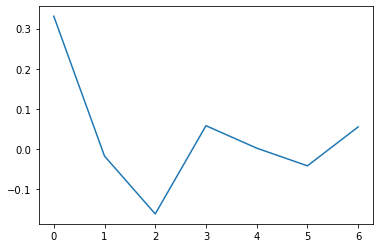

In [218]:
SEQS = [
    ('GRBP5','IMVTESSDYSSY'), #->, -----22---220
    ('M6','IMVTASSAYDDY')    #->  -----22---550
]
s1 = np.fft.rfft(list(dat1['grbp5_sim'].pep_data['EIIP_Seq'].iloc[1]))
s1 = np.fft.rfft(list(dat1['grbp5_sim'].pep_data['EIIP_Seq'].iloc[2]))
s1 = np.fft.rfft(list(dat1['grbp5_sim'].pep_data['EIIP_Seq'].iloc[3]))
plt.plot(np.real(s1))
plt.show()

In [123]:
dat1['grbp5_sim'].pep_data


,Sequences,PAM30,BLOSUM,RRM_SN,RRM_Corr,NUM_Seq,EIIP_Seq,FNS_Seq,sseq_matches,weighted_matches,jaro_winkler,needleman_wunsch,smith_waterman,levenshtein
13,SVPHFSDEDKDP,0.556054,0.650307,0.300565,0.499344,213602555653,"(0.0829, 0.0057, 0.0198, 0.0242, 0.0946, 0.082...","(Polar, Hydrophobic, Proline, Charge (+), Arom...","[(S, 5)]",0.255479,0.477778,0.541667,0.166667,0.166667
14,VPHFSDEDKDPE,0.488789,0.570552,0.877714,0.704747,136025556535,"(0.0057, 0.0198, 0.0242, 0.0946, 0.0829, 0.126...","(Hydrophobic, Proline, Charge (+), Aromatic, P...","[(D, 7)]",0.255479,0.472222,0.541667,0.083333,0.083333
28,SVPHFSEEEKEA,0.730942,0.797546,0.460040,0.268815,213602555651,"(0.0829, 0.0057, 0.0198, 0.0242, 0.0946, 0.082...","(Polar, Hydrophobic, Proline, Charge (+), Arom...","[(S, 5)]",0.255479,0.472222,0.541667,0.083333,0.083333
29,VPHFSEEEKEAE,0.663677,0.717791,0.447358,0.197498,136025556515,"(0.0057, 0.0198, 0.0242, 0.0946, 0.0829, 0.005...","(Hydrophobic, Proline, Charge (+), Aromatic, P...",[],0.000000,0.388889,0.500000,0.000000,0.000000
58,SVPHFSEEEKEP,0.643498,0.705521,0.440444,0.248079,213602555653,"(0.0829, 0.0057, 0.0198, 0.0242, 0.0946, 0.082...","(Polar, Hydrophobic, Proline, Charge (+), Arom...","[(S, 5)]",0.255479,0.472222,0.541667,0.083333,0.083333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26615,LQKIAEKFSGTR,0.553812,0.601227,0.552629,0.445060,126115602426,"(0.0, 0.0761, 0.0371, 0.0, 0.0373, 0.0058, 0.0...","(Hydrophobic, Polar, Charge (+), Hydrophobic, ...",[],0.000000,0.500000,0.500000,0.000000,0.000000
26824,NTRGSWSNKRLS,0.645740,0.644172,0.611456,0.539866,226420226612,"(0.0036, 0.0941, 0.0959, 0.005, 0.0829, 0.0548...","(Polar, Polar, Charge (+), Glycine, Polar, Aro...","[(S, 6)]",0.255479,0.555556,0.541667,0.083333,0.083333
26825,TRGSWSNKRLSP,0.553812,0.564417,0.479794,0.497122,264202266123,"(0.0941, 0.0959, 0.005, 0.0829, 0.0548, 0.0829...","(Polar, Charge (+), Glycine, Polar, Aromatic, ...","[(S, 5), (S, 10)]",0.510958,0.555556,0.583333,0.166667,0.166667
26826,RGSWSNKRLSPR,0.443946,0.447853,0.548359,0.529644,642022661236,"(0.0959, 0.005, 0.0829, 0.0548, 0.0829, 0.0036...","(Charge (+), Glycine, Polar, Aromatic, Polar, ...","[(S, 9)]",0.255479,0.500000,0.541667,0.083333,0.083333


In [ ]:
data['m6_sim'].pep_data

sorted_grbp5_sim_match = data['grbp5_sim_match'].pep_data.sort_values(by="weighted_matches")
# grbp5_sim.pep_data.to_csv('../out/grbp5_data_v2.csv')
# m6_sim.pep_data.to_csv('../out/m6_data_v2.csv')
# both_sep_sim.to_csv('../out/grbp5_m6_sep_v2.csv')
# both_avg_sim.to_csv('../out/grbp5_m6_avg_v2.csv')


In [12]:
m6_sim.pep_data
grbp5_sim.pep_data
both_avg = m6_sim.merge_data(other=grbp5_sim, sep_cols=False).cov()
both_split = m6_sim.merge_data(other=grbp5_sim, sep_cols=True).corr()
print(both_split.__repr__)
both_split

NameError: name 'm6_sim' is not defined

In [818]:
m6_sim.pep_data.groupby('sequence_matches')

KeyError: 'sequence_matches'

In [ ]:
print(m6_sim.sseqs)
print(m6_sim.pep_data.corr())
m6_ss = m6_sim.get_df_with_binder_subseqs()
grb_ss = grbp5_sim.get_df_with_binder_subseqs()
grb_ss[grb_ss['sseq_matches'].str.len() > 2]

In [700]:
GRBP5 = 'IMVTESSDYSSY'
M6 = 'IMVTASSAYDDY'
print(len(m6_sim.sseqs))
m6_sim.pep_data.sort_values(by='RRM_SN', ascending=False)
grbp5_sim.pep_data.sort_values(by='RRM_SN', ascending=False)

78


,Sequences,PAM30,BLOSUM,RRM_SN,RRM_Corr,NUM_Seq,EIIP_Seq,FNS_Seq,sseq_matches,weighted_matches
24971,IINDVKNELFPE,0.596413,0.533742,1.000000,0.296137,"[1, 1, 2, 5, 1, 6, 2, 5, 1, 0, 3, 5]","[0.0, 0.0, 0.0036, 0.1263, 0.0057, 0.0371, 0.0...","[Hydrophobic, Hydrophobic, Polar, Charge (-), ...","[(I, 0)]",0.157895
13363,ELVHNKARPYIL,0.466368,0.466258,0.979171,0.257179,"[5, 1, 1, 6, 2, 6, 1, 6, 3, 0, 1, 1]","[0.0058, 0.0, 0.0057, 0.0242, 0.0036, 0.0371, ...","[Charge (-), Hydrophobic, Hydrophobic, Charge ...","[(V, 2)]",0.157895
26494,GAEDVGLQPRLV,0.345291,0.337423,0.975570,0.395459,"[4, 1, 5, 5, 1, 4, 1, 2, 3, 6, 1, 1]","[0.005, 0.0373, 0.0058, 0.1263, 0.0057, 0.005,...","[Glycine, Hydrophobic, Charge (-), Charge (-),...",[],0.000000
2313,PLGFLSQDHSVN,0.495516,0.601227,0.974491,0.555219,"[3, 1, 4, 0, 1, 2, 2, 5, 6, 2, 1, 2]","[0.0198, 0.0, 0.005, 0.0946, 0.0, 0.0829, 0.07...","[Proline, Hydrophobic, Glycine, Aromatic, Hydr...","[(S, 5), (D, 7), (S, 9)]",0.473684
24969,NSIINDVKNELF,0.755605,0.693252,0.974118,0.375650,"[2, 2, 1, 1, 2, 5, 1, 6, 2, 5, 1, 0]","[0.0036, 0.0829, 0.0, 0.0, 0.0036, 0.1263, 0.0...","[Polar, Polar, Hydrophobic, Hydrophobic, Polar...",[],0.000000
...,...,...,...,...,...,...,...,...,...,...
10853,LNSLDGAGFGFE,0.446188,0.435583,0.080443,0.200565,"[1, 2, 2, 1, 5, 4, 1, 4, 0, 4, 0, 5]","[0.0, 0.0036, 0.0829, 0.0, 0.1263, 0.005, 0.03...","[Hydrophobic, Polar, Polar, Hydrophobic, Charg...",[],0.000000
16963,DGVLNLYPFPRV,0.318386,0.306748,0.078664,0.175543,"[5, 4, 1, 1, 2, 1, 0, 3, 0, 3, 6, 1]","[0.1263, 0.005, 0.0057, 0.0, 0.0036, 0.0, 0.05...","[Charge (-), Glycine, Hydrophobic, Hydrophobic...","[(V, 2)]",0.157895
26493,AGAEDVGLQPRL,0.374439,0.349693,0.053532,0.159949,"[1, 4, 1, 5, 5, 1, 4, 1, 2, 3, 6, 1]","[0.0373, 0.005, 0.0373, 0.0058, 0.1263, 0.0057...","[Hydrophobic, Glycine, Hydrophobic, Charge (-)...",[],0.000000
24970,SIINDVKNELFP,0.663677,0.613497,0.043873,0.135665,"[2, 1, 1, 2, 5, 1, 6, 2, 5, 1, 0, 3]","[0.0829, 0.0, 0.0, 0.0036, 0.1263, 0.0057, 0.0...","[Polar, Hydrophobic, Hydrophobic, Polar, Charg...",[],0.000000


In [590]:
m6_sim.get_df_with_binder_subseqs()
grbp5_sim.get_df_with_binder_subseqs()

,Sequences,EIIP_Seq,NUM_Seq,PAM30,BLOSUM,RRM_SN,RRM_Corr,FNS_Seq,sseq_matches,weighted_matches
400,IRYHQCYFNPIS,"[0.0, 0.0959, 0.0516, 0.0242, 0.0761, 0.0829, ...","[1, 6, 0, 6, 2, 7, 0, 0, 2, 3, 1, 2]",46.860987,54.601227,79.713758,56.159889,None,"[(I, 0)]",15.789474
584,IRYHQCYFNPIS,"[0.0, 0.0959, 0.0516, 0.0242, 0.0761, 0.0829, ...","[1, 6, 0, 6, 2, 7, 0, 0, 2, 3, 1, 2]",46.860987,54.601227,79.713758,56.159889,None,"[(I, 0)]",15.789474
615,IRYRQCYFNPIS,"[0.0, 0.0959, 0.0516, 0.0959, 0.0761, 0.0829, ...","[1, 6, 0, 6, 2, 7, 0, 0, 2, 3, 1, 2]",46.188341,50.306748,82.946280,65.847833,None,"[(I, 0)]",15.789474
1081,IRYHQCYFNPIS,"[0.0, 0.0959, 0.0516, 0.0242, 0.0761, 0.0829, ...","[1, 6, 0, 6, 2, 7, 0, 0, 2, 3, 1, 2]",46.860987,54.601227,79.713758,56.159889,None,"[(I, 0)]",15.789474
1888,INDDCPNLIGNR,"[0.0, 0.0036, 0.1263, 0.1263, 0.0829, 0.0198, ...","[1, 2, 5, 5, 7, 3, 2, 1, 1, 4, 2, 6]",49.327354,32.515337,57.852101,35.955359,None,"[(I, 0)]",15.789474
...,...,...,...,...,...,...,...,...,...,...
27481,QGPWLEEEEEAY,"[0.0761, 0.005, 0.0198, 0.0548, 0.0, 0.0058, 0...","[2, 4, 3, 0, 1, 5, 5, 5, 5, 5, 1, 0]",38.565022,49.693252,40.556591,13.948948,None,"[(Y, 11)]",15.789474
27899,ERPRMEEEEEAY,"[0.0058, 0.0959, 0.0198, 0.0959, 0.0823, 0.005...","[5, 6, 3, 6, 1, 5, 5, 5, 5, 5, 1, 0]",57.847534,60.736196,61.755373,32.448511,None,"[(Y, 11)]",15.789474
28099,QHGAAPECFWKY,"[0.0761, 0.0242, 0.005, 0.0373, 0.0373, 0.0198...","[2, 6, 4, 1, 1, 3, 5, 7, 0, 0, 6, 0]",25.112108,34.969325,51.586048,39.468721,None,"[(Y, 11)]",15.789474
28621,QHGTAPECFWKY,"[0.0761, 0.0242, 0.005, 0.0941, 0.0373, 0.0198...","[2, 6, 4, 2, 1, 3, 5, 7, 0, 0, 6, 0]",27.130045,38.650307,57.473474,47.143410,None,"[(T, 3), (Y, 11)]",31.578947


In [569]:
m6_sim.pep_data.corr()

,PAM30,BLOSUM,RRM_SN,RRM_Corr,weighted_matches
PAM30,1.000000,0.908415,0.029558,0.035752,0.325778
BLOSUM,0.908415,1.000000,0.008276,0.231969,0.324896
RRM_SN,0.029558,0.008276,1.000000,0.331186,-0.126358
RRM_Corr,0.035752,0.231969,0.331186,1.000000,-0.016105
weighted_matches,0.325778,0.324896,-0.126358,-0.016105,1.000000


# Get RRM S/N similarity

In [12]:
def get_RRM():
    data = similarity.pep_data
    matrix = similarity.data['PA]
    print(data.head(), len(data))
    
get_RRM()

       Sequences                                           EIIP_Seq  \
13  SVPHFSDEDKDP  [0.0829, 0.0057, 0.0198, 0.0242, 0.0946, 0.082...   
14  VPHFSDEDKDPE  [0.0057, 0.0198, 0.0242, 0.0946, 0.0829, 0.126...   
28  SVPHFSEEEKEA  [0.0829, 0.0057, 0.0198, 0.0242, 0.0946, 0.082...   
29  VPHFSEEEKEAE  [0.0057, 0.0198, 0.0242, 0.0946, 0.0829, 0.005...   
43  SVPHFSDEDKDP  [0.0829, 0.0057, 0.0198, 0.0242, 0.0946, 0.082...   

                                 Num_Seq PAM30 BLOSUM RRM_SN RRM_Corr  
13  [2, 1, 3, 6, 0, 2, 5, 5, 5, 6, 5, 3]  None   None   None     None  
14  [1, 3, 6, 0, 2, 5, 5, 5, 6, 5, 3, 5]  None   None   None     None  
28  [2, 1, 3, 6, 0, 2, 5, 5, 5, 6, 5, 1]  None   None   None     None  
29  [1, 3, 6, 0, 2, 5, 5, 5, 6, 5, 1, 5]  None   None   None     None  
43  [2, 1, 3, 6, 0, 2, 5, 5, 5, 6, 5, 3]  None   None   None     None   3079


# Get BLOSUM similarity

In [29]:
def get_BLOSUM_similarity():
    data = similarity.pep_data
    binders = similarity.binders
    BLOSUM = similarity.data['BLOSUM']
    for binder in binders:
        for pep in data['Sequences']:
            dist = 0
            for aa1 in pep:
                for aa2 in binder:
                    dist += BLOSUM[aa1].loc[aa2]
                    
    print(data['Sequences'])
    print(binders)
    print(BLOSUM)
    
#get_BLOSUM_similarity()
similarity.data['BLOSUM']

,A,R,N,D,C,Q,E,G,H,I,...,P,S,T,W,Y,V,B,Z,X,*
A,4,-1,-2,-2,0,-1,-1,0,-2,-1,...,-1,1,0,-3,-2,0,-2,-1,0,-4
R,-1,5,0,-2,-3,1,0,-2,0,-3,...,-2,-1,-1,-3,-2,-3,-1,0,-1,-4
N,-2,0,6,1,-3,0,0,0,1,-3,...,-2,1,0,-4,-2,-3,3,0,-1,-4
D,-2,-2,1,6,-3,0,2,-1,-1,-3,...,-1,0,-1,-4,-3,-3,4,1,-1,-4
C,0,-3,-3,-3,9,-3,-4,-3,-3,-1,...,-3,-1,-1,-2,-2,-1,-3,-3,-2,-4
Q,-1,1,0,0,-3,5,2,-2,0,-3,...,-1,0,-1,-2,-1,-2,0,3,-1,-4
E,-1,0,0,2,-4,2,5,-2,0,-3,...,-1,0,-1,-3,-2,-2,1,4,-1,-4
G,0,-2,0,-1,-3,-2,-2,6,-2,-4,...,-2,0,-2,-2,-3,-3,-1,-2,-1,-4
H,-2,0,1,-1,-3,0,0,-2,8,-3,...,-2,-1,-2,-2,2,-3,0,0,-1,-4
I,-1,-3,-3,-3,-1,-3,-3,-4,-3,4,...,-3,-2,-1,-3,-1,3,-3,-3,-1,-4


# Get PAM30 similiarity

# REVELATION
What if... maybe... instead of handling binder as a dict, handle AT MOST one input string as the binder sequence so there is a one:one correspondence between the class and the sequence for similarity calculations???